## Installing and importing the necessary Libraries


In [ ]:
## Installing sentence transformers
!pip install sentence-transformers==2.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.4 MB/s eta 0:00:00


In [ ]:
## Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score, auc, make_scorer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer, models
from sklearn.metrics import accuracy_score, f1_score
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import GridSearchCV
import random
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
warnings.filterwarnings("ignore")

## Converting 'Roberta-Large' to Sentence Transformer by performing pooling on the token embeddings


In [ ]:
from sentence_transformers import SentenceTransformer, models
## using pretrained microsoft/mpnet-base model
transformer_model = models.Transformer('FacebookAI/roberta-large')
## using mean pool function over the token embeddings to get fixed dimension embeddings
pooling_model = models.Pooling(transformer_model.get_word_embedding_dimension(),pooling_mode_mean_tokens=True)
## Creating the sentence transformer model
model_base = SentenceTransformer(modules=[transformer_model, pooling_model])


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Reading in the data

In [ ]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["train"])

In [ ]:
# Reading in the IMDB data
splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'test': 'plain_text/test-00000-of-00001.parquet', 'unsupervised': 'plain_text/unsupervised-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/stanfordnlp/imdb/" + splits["test"])

In [ ]:
## Renaming "text" as "Text"
df1=df.rename(columns={"text": "Text"})
df1.info()
df_test=df_test.rename(columns={"text": "Text"})
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


## Data Distribution

In [ ]:
df1.label.value_counts(ascending=True)

,count
label,
0,12500
1,12500


## Preparing the data for encoding

In [ ]:
## Converting to list for downstream processing
X_train = df1['Text']
X_test = df_test['Text']
X_train_list=df1['Text'].tolist()
X_test_list=df_test['Text'].tolist()
y_train=df1['label']
y_test=df_test['label']

## Encoding the texts using the Base Sentence Transformer Model and running Classification Algorithms

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model_base.encode(X_train_list, show_progress_bar = True)
vect_test = model_base.encode(X_test_list, show_progress_bar = True)

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
# Running LGBoost algorithm for classification
lgbm_model = LGBMClassifier(objective='binary', random_state=5)
lgbm_model.fit(vect_train, y_train)
# evaluate the model
y_pred = lgbm_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Number of positive: 12500, number of negative: 12500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 25000, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Confusion Matrix - 
 [[11258  1242]
 [ 1203 11297]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9035    0.9006    0.9020     12500
           1     0.9009    0.9038    0.9024     12500

    accuracy                         0.9022     25000
   macro avg     0.9022    0.9022    0.9022     25000
weighted avg     0.9022    0.9022    0.9022     25000



In [ ]:
# Running XGBoost algorithm for classification
xgb_model = XGBClassifier(random_state=5)
xgb_model.fit(vect_train, y_train)
# evaluate the model
y_pred = xgb_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

Confusion Matrix - 
 [[11339  1161]
 [ 1106 11394]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9111    0.9071    0.9091     12500
           1     0.9075    0.9115    0.9095     12500

    accuracy                         0.9093     25000
   macro avg     0.9093    0.9093    0.9093     25000
weighted avg     0.9093    0.9093    0.9093     25000



In [ ]:
# evaluate SVM algorithm for classification
# define the model
svm_model = svm.SVC(kernel='rbf', probability=True)
svm_model.fit(vect_train, y_train)
# evaluate the model
y_pred = svm_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

Confusion Matrix - 
 [[11237  1263]
 [ 1104 11396]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9105    0.8990    0.9047     12500
           1     0.9002    0.9117    0.9059     12500

    accuracy                         0.9053     25000
   macro avg     0.9054    0.9053    0.9053     25000
weighted avg     0.9054    0.9053    0.9053     25000



## Encoding the texts using the Base Sentence Transformer Model finetuned on CosineSimilarityLoss and running Classification Algorithms

In [ ]:
## Creating a function for transforming our dataset for finetuning the Sentence Transformers model on CosineSimilarityLoss
def input_example_generation(X_train, y_train, triplets, num_itr):
  train = pd.concat([X_train, y_train], axis=1)
  train_pos = train.loc[train["label"] == 1]
  train_neg = train.loc[train["label"] == 0]
  # train_neu = train.loc[train["sentiment"] == 1]
  train_pos_text_list = train_pos["Text"].tolist()
  train_neg_text_list = train_neg["Text"].tolist()
  # train_neu_text_list = train_neu["Text"].tolist()
  for x in range((num_itr)):
    for y in range(len(train_pos_text_list)):
      count = x*len(train_pos_text_list) + y
      # Setting the seed value to get the same set of random texts everytime
      random.seed(count)
      torch.manual_seed(count)
      # For each positive sentiment text, randomly selecting another positive text sentence and appending to triplet with target similarity score as 1.0
      currentSentence = train_pos_text_list[y]
      posSentence = random.choice(train_pos_text_list)
      triplets.append(InputExample(texts=[currentSentence, posSentence], label=1.0))
      # For each positive sentiment text, randomly selecting a negative sentiment text and appending to triplet with target similarity score as 0
      negSentence = random.choice(train_neg_text_list)
      triplets.append(InputExample(texts=[currentSentence, negSentence], label=0.0))
      # # For each positive sentiment text, randomly selecting a neutral sentiment text and appending to triplet with target similarity score as 0.5
      # neuSentence = random.choice(train_neu_text_list)
      # triplets.append(InputExample(texts=[currentSentence, neuSentence], label=0.5))
  return (triplets)

In [ ]:
## Creating the Input Examples
train_examples = []
num_itr = 5
train_examples = input_example_generation((X_train), (y_train), train_examples,num_itr)
# Defining DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=4)
# Specifying number of epochs and warmup steps
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)

In [ ]:
# Defining Trainloss with loss as CosineSimilarityLoss
model = model_base
train_loss = losses.CosineSimilarityLoss(model)

In [ ]:
# Finetuning the model based on CosineSimilarityLoss
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/31250 [00:00<?, ?it/s]

In [ ]:
import time
start_time = time.time()

In [ ]:
# Encoding the X_train using base sentence transformer model
vect_train = model.encode(X_train_list, show_progress_bar = True)
vect_test = model.encode(X_test_list, show_progress_bar = True)

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
# evaluate SVM algorithm for classification
# define the model
svm_model = svm.SVC(kernel='rbf', probability=True)
svm_model.fit(vect_train, y_train)
# evaluate the model
y_pred = svm_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

Confusion Matrix - 
 [[11920   580]
 [  447 12053]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9639    0.9536    0.9587     12500
           1     0.9541    0.9642    0.9591     12500

    accuracy                         0.9589     25000
   macro avg     0.9590    0.9589    0.9589     25000
weighted avg     0.9590    0.9589    0.9589     25000



In [ ]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 675.4694254398346 seconds


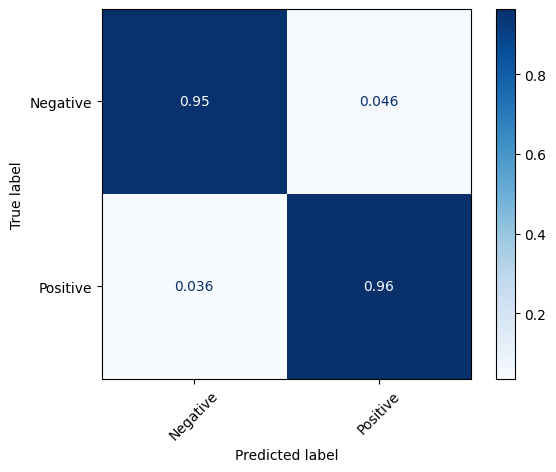

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(svm_model, vect_test, y_test,normalize='true',cmap = 'Blues', xticks_rotation=45, display_labels=["Negative", "Positive"])

In [ ]:
# Running LGBoost algorithm for classification
lgbm_model = LGBMClassifier(objective='binary', random_state=5)
lgbm_model.fit(vect_train, y_train)
# evaluate the model
y_pred = lgbm_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

[LightGBM] [Info] Number of positive: 12500, number of negative: 12500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261120
[LightGBM] [Info] Number of data points in the train set: 25000, number of used features: 1024
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Confusion Matrix - 
 [[12080   420]
 [  681 11819]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9466    0.9664    0.9564     12500
           1     0.9657    0.9455    0.9555     12500

    accuracy                         0.9560     25000
   macro avg     0.9562    0.9560    0.9560     25000
weighted avg     0.9562    0.9560    0.9560     25000



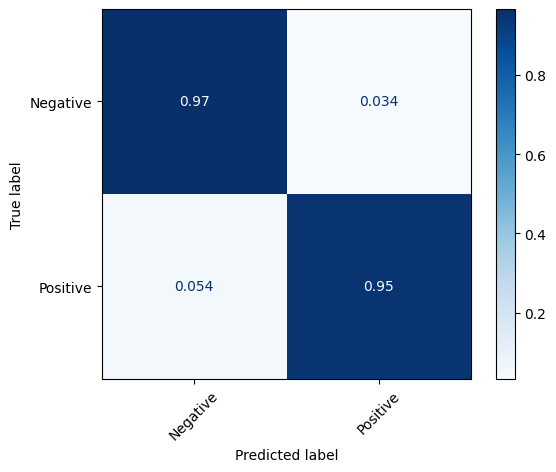

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(best_model, vect_test, y_test,normalize='true',cmap = 'Blues', xticks_rotation=45, display_labels=["Negative", "Positive"])

In [ ]:
# Running XGBoost algorithm for classification
xgb_model = XGBClassifier(random_state=5)
xgb_model.fit(vect_train, y_train)
# evaluate the model
y_pred = xgb_model.predict(vect_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)
print("Confusion Matrix - \n",conf_m)
print("Classification report - \n",report)

Confusion Matrix - 
 [[12035   465]
 [  653 11847]]
Classification report - 
               precision    recall  f1-score   support

           0     0.9485    0.9628    0.9556     12500
           1     0.9622    0.9478    0.9549     12500

    accuracy                         0.9553     25000
   macro avg     0.9554    0.9553    0.9553     25000
weighted avg     0.9554    0.9553    0.9553     25000



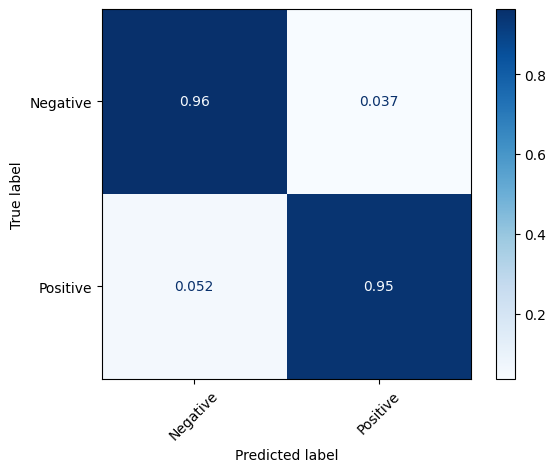

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(best_model, vect_test, y_test,normalize='true',cmap = 'Blues', xticks_rotation=45, display_labels=["Negative", "Positive"])